In [607]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

In [608]:
def preprocess_data(features, labels=None):
    if labels is not None:
        features = features.join(labels)
    features.reset_index(inplace=True)
    features.set_index('week_start_date',inplace=True)
    features = features.drop('year', axis=1)

    features = features.interpolate(method="quadratic")
    if labels is not None:
        return features.drop('total_cases', axis=1), features['total_cases']
    else:
        return features

def get_data(features_path, labels_path=None):
    if labels_path is not None:
        labels = pd.read_csv(labels_path,
                           index_col=[0,1,2])

    features = pd.read_csv(features_path,
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

    # Separate data for San Juan
    sj_features = features.loc['sj']
    if labels_path is not None:
        sj_labels = labels.loc['sj']

    # Separate data for Iquitos
    iq_features = features.loc['iq']
    if labels_path is not None:
        iq_labels = labels.loc['iq']

    if labels_path is not None:
        sj_f, sj_l = preprocess_data(sj_features, sj_labels)
        iq_f, iq_l = preprocess_data(iq_features, iq_labels)
        return sj_f, sj_l, iq_f, iq_l

    return preprocess_data(sj_features, None), preprocess_data(iq_features, None)


In [609]:
sj_X_data, sj_y_data, iq_X_data, iq_y_data = get_data('dengue_features_train.csv',
                                                        'dengue_labels_train.csv')

# load the provided data
train_features = pd.read_csv('dengue_features_train.csv',
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

train_labels = pd.read_csv('dengue_labels_train.csv',
                           index_col=[0,1,2])

# Separate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

sj_X_train, sj_y_train = preprocess_data(sj_train_features,sj_train_labels)

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

iq_X_train, iq_y_train = preprocess_data(iq_train_features,iq_train_labels)

In [610]:
#split data in train and test
sj_X_train, sj_X_test, sj_y_train, sj_y_test = train_test_split(
    sj_X_data, sj_y_data, test_size=0.3, shuffle=False)

iq_X_train, iq_X_test, iq_y_train, iq_y_test = train_test_split(
iq_X_data, iq_y_data, test_size=0.3, shuffle=False)


In [611]:
sj_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
weekofyear,655.0,26.810687,14.858483,1.000000,14.000000,27.000000,40.000000,53.000000
ndvi_ne,655.0,0.086158,0.096638,-0.290200,0.032292,0.082800,0.129210,0.446267
ndvi_nw,655.0,0.084960,0.106930,-0.567938,0.044733,0.085600,0.134550,0.437100
ndvi_se,655.0,0.170185,0.094370,-0.556810,0.140464,0.177643,0.212529,0.393129
ndvi_sw,655.0,0.163893,0.063279,-0.111362,0.129112,0.167943,0.203043,0.381420
precipitation_amt_mm,655.0,34.365767,41.398842,-15.492810,0.705000,21.530000,50.610000,287.550000
reanalysis_air_temp_k,655.0,299.020389,1.181711,295.938571,298.015714,299.215714,299.980714,301.255714
reanalysis_avg_temp_k,655.0,299.128194,1.159116,296.114286,298.160714,299.314286,300.053571,301.407143
reanalysis_dew_point_temp_k,655.0,295.064769,1.568129,289.642857,293.820714,295.447143,296.355714,297.467143
reanalysis_max_air_temp_k,655.0,301.255595,1.199172,298.200000,300.400000,301.400000,302.300000,303.900000


In [612]:
iq_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
weekofyear,364.0,26.431319,14.973924,1.000000,13.750000,26.000000,39.000000,53.000000
ndvi_ne,364.0,0.267057,0.081455,0.088616,0.204575,0.267829,0.323507,0.488400
ndvi_nw,364.0,0.233889,0.075983,0.035860,0.178186,0.226736,0.289986,0.428771
ndvi_se,364.0,0.251451,0.076860,0.029880,0.195130,0.250836,0.305611,0.473400
ndvi_sw,364.0,0.264058,0.083723,0.064183,0.206225,0.261300,0.321064,0.546017
precipitation_amt_mm,364.0,64.413590,34.986159,0.000000,39.452500,60.850000,86.507500,173.450000
reanalysis_air_temp_k,364.0,297.856586,1.193372,294.635714,297.062857,297.822857,298.588214,301.637143
reanalysis_avg_temp_k,364.0,299.129271,1.346382,294.892857,298.217857,299.121429,300.108929,302.928571
reanalysis_dew_point_temp_k,364.0,295.318981,1.478115,290.088571,294.344643,295.740000,296.457857,297.852857
reanalysis_max_air_temp_k,364.0,307.190040,2.456329,300.000000,305.200000,307.200000,308.900000,314.000000


In [613]:
# compute the correlations
sj_correlations = sj_X_train.corr()
iq_correlations = iq_X_train.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

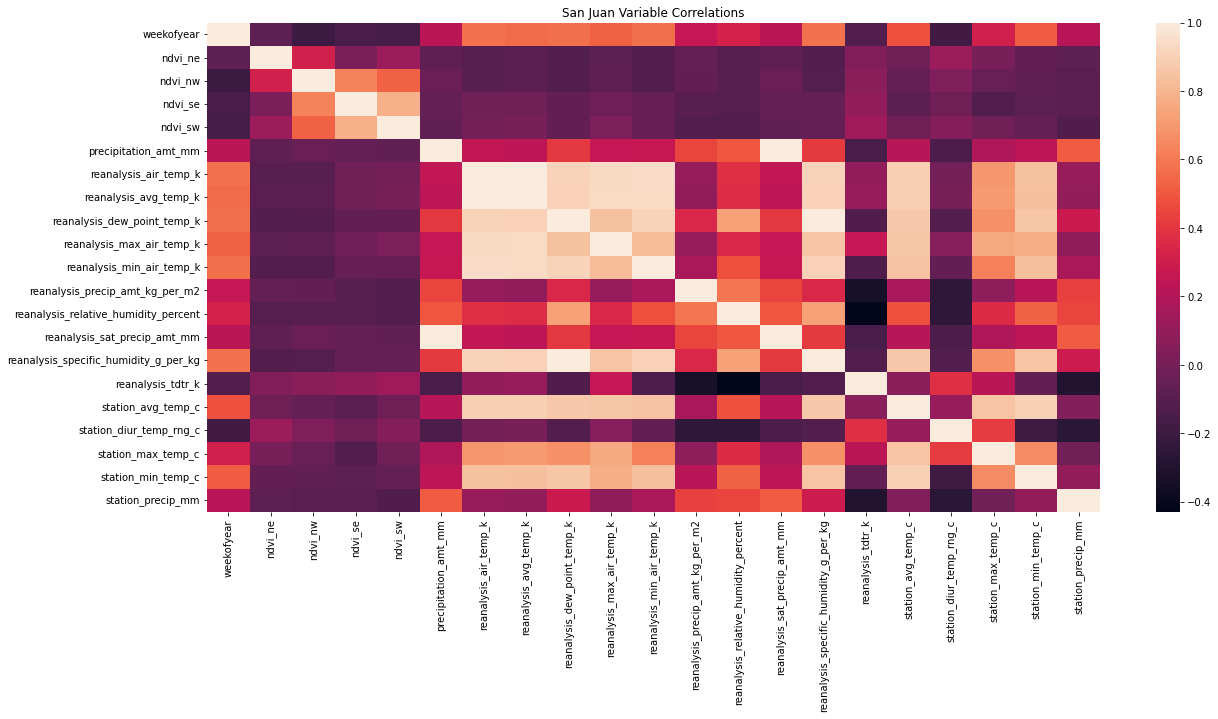

In [614]:
plt.rcParams["figure.figsize"] = (20,9)

# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

In [615]:
sj_rf = XGBRegressor(max_depth=12,learning_rate=.01,n_estimators=300,n_jobs=-1) 
sj_rf.fit(sj_X_train, sj_y_train)
print(mean_absolute_error(sj_y_train, sj_rf.predict(sj_X_train)))
print(mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))

/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


3.8029702308523747
23.823140923238736


/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [616]:
sj_rf.feature_importances_

array([0.03688177, 0.00734173, 0.00364426, 0.50827116, 0.01035302,
       0.00412764, 0.00676945, 0.0169113 , 0.02372544, 0.01620453,
       0.0159432 , 0.01825673, 0.04316385, 0.        , 0.16100526,
       0.02062052, 0.01736021, 0.0121929 , 0.02558369, 0.03132512,
       0.02031822], dtype=float32)

<AxesSubplot:ylabel='cols'>

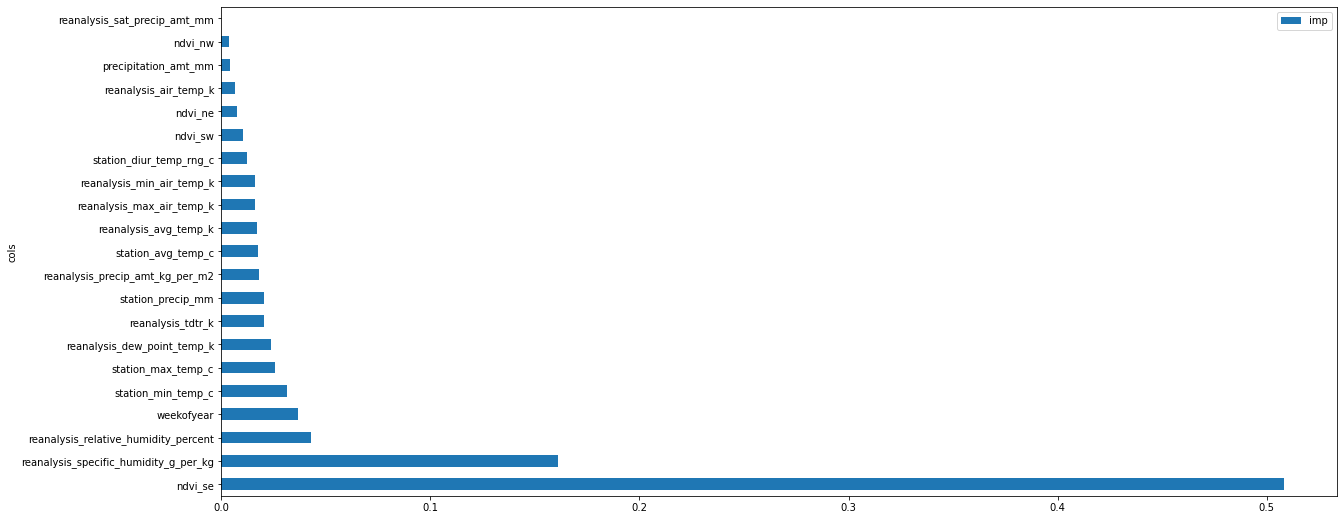

In [617]:
plt.rcParams["figure.figsize"] = (20,9)
(pd.DataFrame(dict(cols=sj_X_train.columns, imp=sj_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

In [618]:
iq_rf = XGBRegressor(max_depth=12,learning_rate=0.01,n_estimators=300,n_jobs=-1) 
iq_rf.fit(iq_X_train, iq_y_train)
print(mean_absolute_error(iq_y_train, iq_rf.predict(iq_X_train)))
print(mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.663949823605695
7.835117244281066


/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [619]:
iq_rf.feature_importances_

array([0.01296161, 0.01024186, 0.00910357, 0.00985306, 0.01442879,
       0.01100932, 0.01475013, 0.01800518, 0.1385702 , 0.02620587,
       0.00369375, 0.0112061 , 0.00676836, 0.        , 0.5729564 ,
       0.00920619, 0.01999491, 0.00990457, 0.01521599, 0.06821385,
       0.01771025], dtype=float32)

<AxesSubplot:ylabel='cols'>

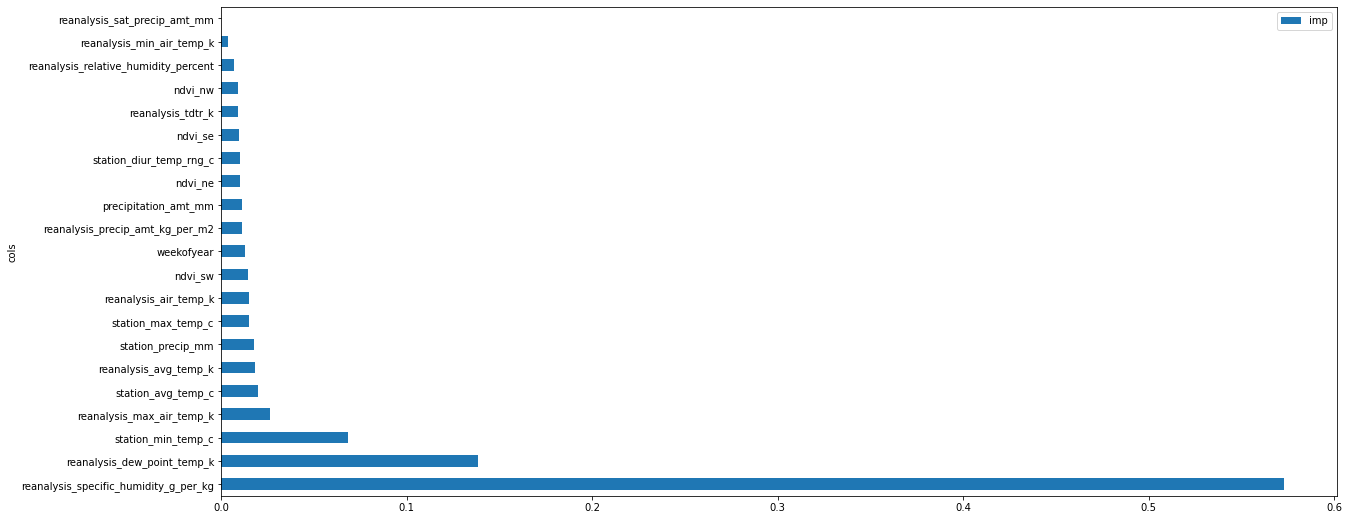

In [620]:
plt.rcParams["figure.figsize"] = (20,9)
plt.rcParams["figure.figsize"] = (20,9)
(pd.DataFrame(dict(cols=iq_X_train.columns, imp=iq_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


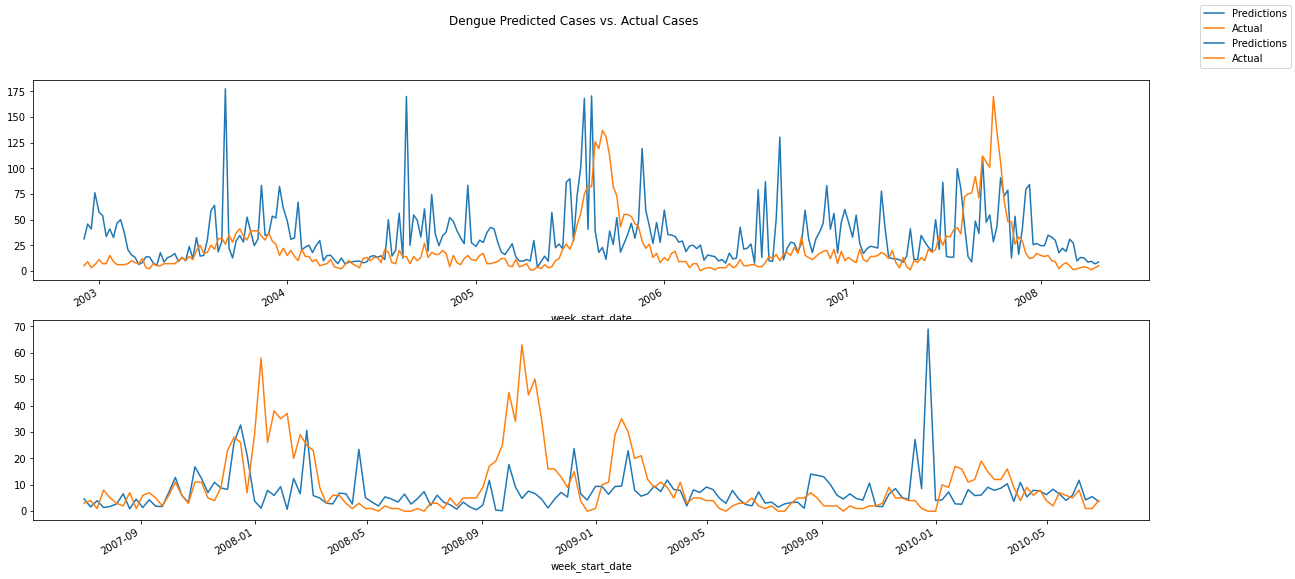

In [621]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_X_test['fitted'] = sj_rf.predict(sj_X_test)
sj_X_test.fitted.plot(ax=axes[0], label="Predictions")
sj_y_test.plot(ax=axes[0], label="Actual")

iq_X_test['fitted'] = iq_rf.predict(iq_X_test)
iq_X_test.fitted.plot(ax=axes[1], label="Predictions")
iq_y_test.plot(ax=axes[1], label="Actual")

figs.suptitle("Dengue Predicted Cases vs. Actual Cases")
figs.legend()

In [622]:
sj_X_test.drop('fitted',axis=1,inplace=True)
iq_X_test.drop('fitted',axis=1,inplace=True)

In [623]:
#submit data
sj_X_valid, iq_X_valid = get_data('dengue_features_test.csv') 

In [624]:
sj_X_valid

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,,
2008-04-29,18,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
2008-05-06,19,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2008-05-13,20,-0.001500,-0.031051,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
2008-05-20,21,0.052862,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
2008-05-27,22,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-03-26,13,-0.087400,-0.016183,0.156343,0.105186,30.34,298.670000,298.885714,294.675714,301.3,...,2.55,78.780000,30.34,15.985714,3.314286,27.542857,7.942857,33.9,22.8,3.5
2013-04-02,14,-0.203250,-0.077833,0.204171,0.178914,6.55,298.035714,298.157143,294.628571,301.5,...,64.30,81.650000,6.55,15.881429,2.828571,26.642857,6.642857,33.3,22.8,17.6
2013-04-09,15,-0.117600,-0.008200,0.192700,0.170429,0.00,299.057143,299.328571,294.948571,301.5,...,0.70,78.285714,0.00,16.212857,3.171429,27.914286,8.114286,32.8,23.3,9.4


In [625]:
iq_X_valid

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,,
2010-07-02,26,0.183783,0.142500,0.225129,0.150214,82.29,297.648571,299.214286,296.118571,307.9,...,34.11,92.581429,82.29,17.654286,9.428571,27.440,10.760,33.8,21.5,11.2
2010-07-09,27,0.291657,0.272267,0.330700,0.320914,25.30,298.224286,299.464286,294.831429,307.7,...,9.10,83.885714,25.30,16.320000,10.157143,27.025,9.625,33.0,21.2,8.9
2010-07-16,28,0.208543,0.366457,0.212629,0.255514,62.14,297.955714,298.964286,296.417143,306.4,...,61.09,92.057143,62.14,18.030000,9.557143,26.950,10.350,33.4,21.6,22.6
2010-07-23,29,0.089286,0.063214,0.122057,0.081957,47.80,295.715714,296.642857,293.638571,306.4,...,19.60,88.970000,47.80,15.394286,7.828571,26.900,9.700,33.3,14.2,4.8
2010-07-30,30,0.306100,0.327683,0.250086,0.267914,56.30,298.502857,300.000000,293.892857,308.1,...,18.93,78.610000,56.30,15.468571,11.771429,27.050,11.850,33.5,16.9,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-05-28,22,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,295.638571,305.5,...,67.60,89.990000,41.12,17.185714,10.100000,27.400,9.050,32.6,21.8,33.0
2013-06-04,23,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,295.845714,306.3,...,45.70,93.891429,71.52,17.448571,9.657143,27.520,10.720,33.8,21.4,68.0
2013-06-11,24,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,294.894286,304.6,...,45.22,94.967143,78.96,16.410000,7.385714,27.200,10.075,32.6,21.6,93.2


In [626]:
sj_predictions = sj_rf.predict(sj_X_valid).astype(int)
iq_predictions = iq_rf.predict(iq_X_valid).astype(int)

submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("benchmark.csv")

/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [627]:
print('sj', mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))
print('iq', mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

sj 23.823140923238736
iq 7.835117244281066


/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


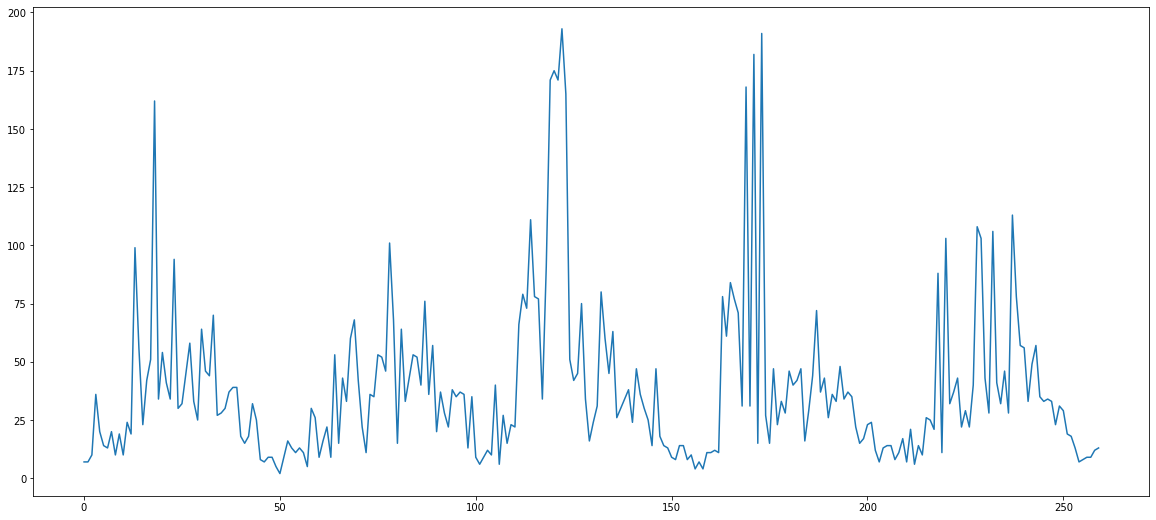

In [628]:
plt.plot(sj_predictions)

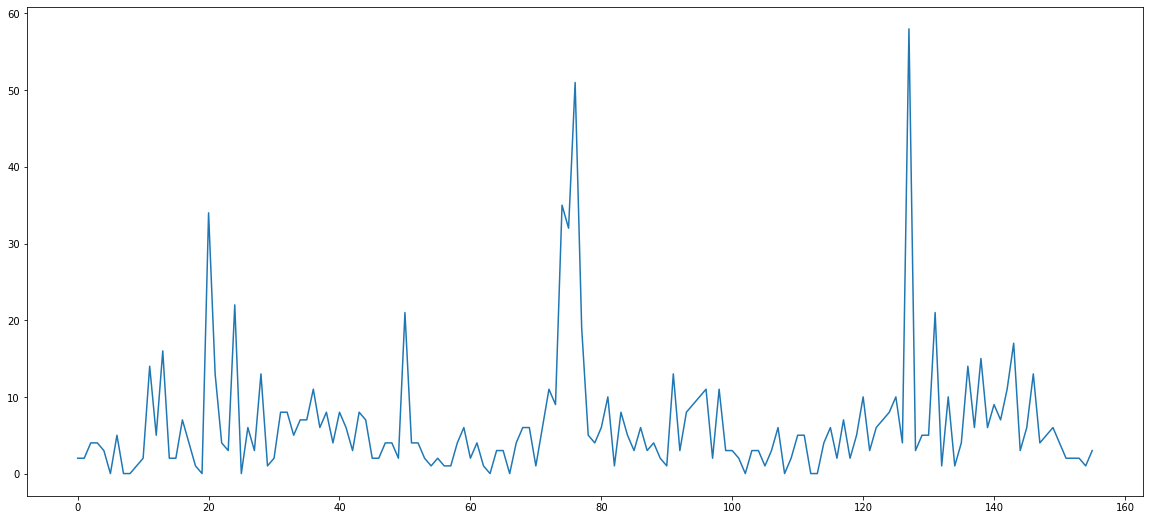

In [629]:
plt.plot(iq_predictions)